# Drum Feature Analysis

**Goal:** Analyze which features are most discriminative for kick/snare/hat classification

This notebook will:
1. Load training data
2. Visualize feature distributions per class
3. Identify most discriminative features
4. Test classification accuracy with different feature subsets
5. Recommend optimal feature set for user training

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.stats import f_oneway

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print('✓ Libraries loaded')

✓ Libraries loaded


## 1. Load and Explore Data

In [3]:
# Load training data
df = pd.read_csv('training_samples.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nClass distribution:")
print(df['label'].value_counts())

# Show first few rows
df.head()

Dataset shape: (21, 27)

Class distribution:
label
kick     11
snare    10
Name: count, dtype: int64


,label,timestamp,flux,energy,band1,band2,band3,band4,band5,centroid,...,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12
0,kick,12.055782,0.018907,0.000286,0.010257,0.008530,0.004335,0.000949,0.000078,39.138997,...,6.832164,6.514226,3.209559,0.638423,-0.959498,-0.837736,0.910679,-0.0,-0.910679,0.837736
1,kick,12.581134,0.025090,0.000549,0.021385,0.008657,0.003813,0.000681,0.000093,24.771646,...,5.391155,3.477108,1.453545,3.006246,2.587793,0.124390,-0.001294,-0.0,0.001294,-0.124390
2,kick,13.112290,0.018440,0.000324,0.012464,0.005048,0.002402,0.000553,0.000091,27.038112,...,7.613212,5.830041,2.478310,2.745393,3.748592,2.430219,0.640408,-0.0,-0.640408,-2.430219
3,kick,13.631837,0.010663,0.000112,0.004685,0.003669,0.002436,0.000679,0.000075,43.978082,...,6.293714,3.175679,0.021012,1.674778,1.200604,-0.628691,0.628015,-0.0,-0.628015,0.628691
4,kick,14.162993,0.019660,0.000284,0.011119,0.010804,0.006425,0.000893,0.000104,40.972518,...,7.708166,6.036940,2.641586,1.777316,0.818150,0.018747,0.128438,-0.0,-0.128438,-0.018747


In [4]:
# Separate features and labels
feature_cols = [col for col in df.columns if col not in ['label', 'timestamp']]
X = df[feature_cols].values
y = df['label'].values

print(f"Features: {feature_cols}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Features: ['flux', 'energy', 'band1', 'band2', 'band3', 'band4', 'band5', 'centroid', 'rolloff', 'flatness', 'low_ratio', 'high_ratio', 'mfcc0', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12']
X shape: (21, 25)
y shape: (21,)


## 2. Feature Distribution Analysis

Visualize how each feature separates the three drum classes

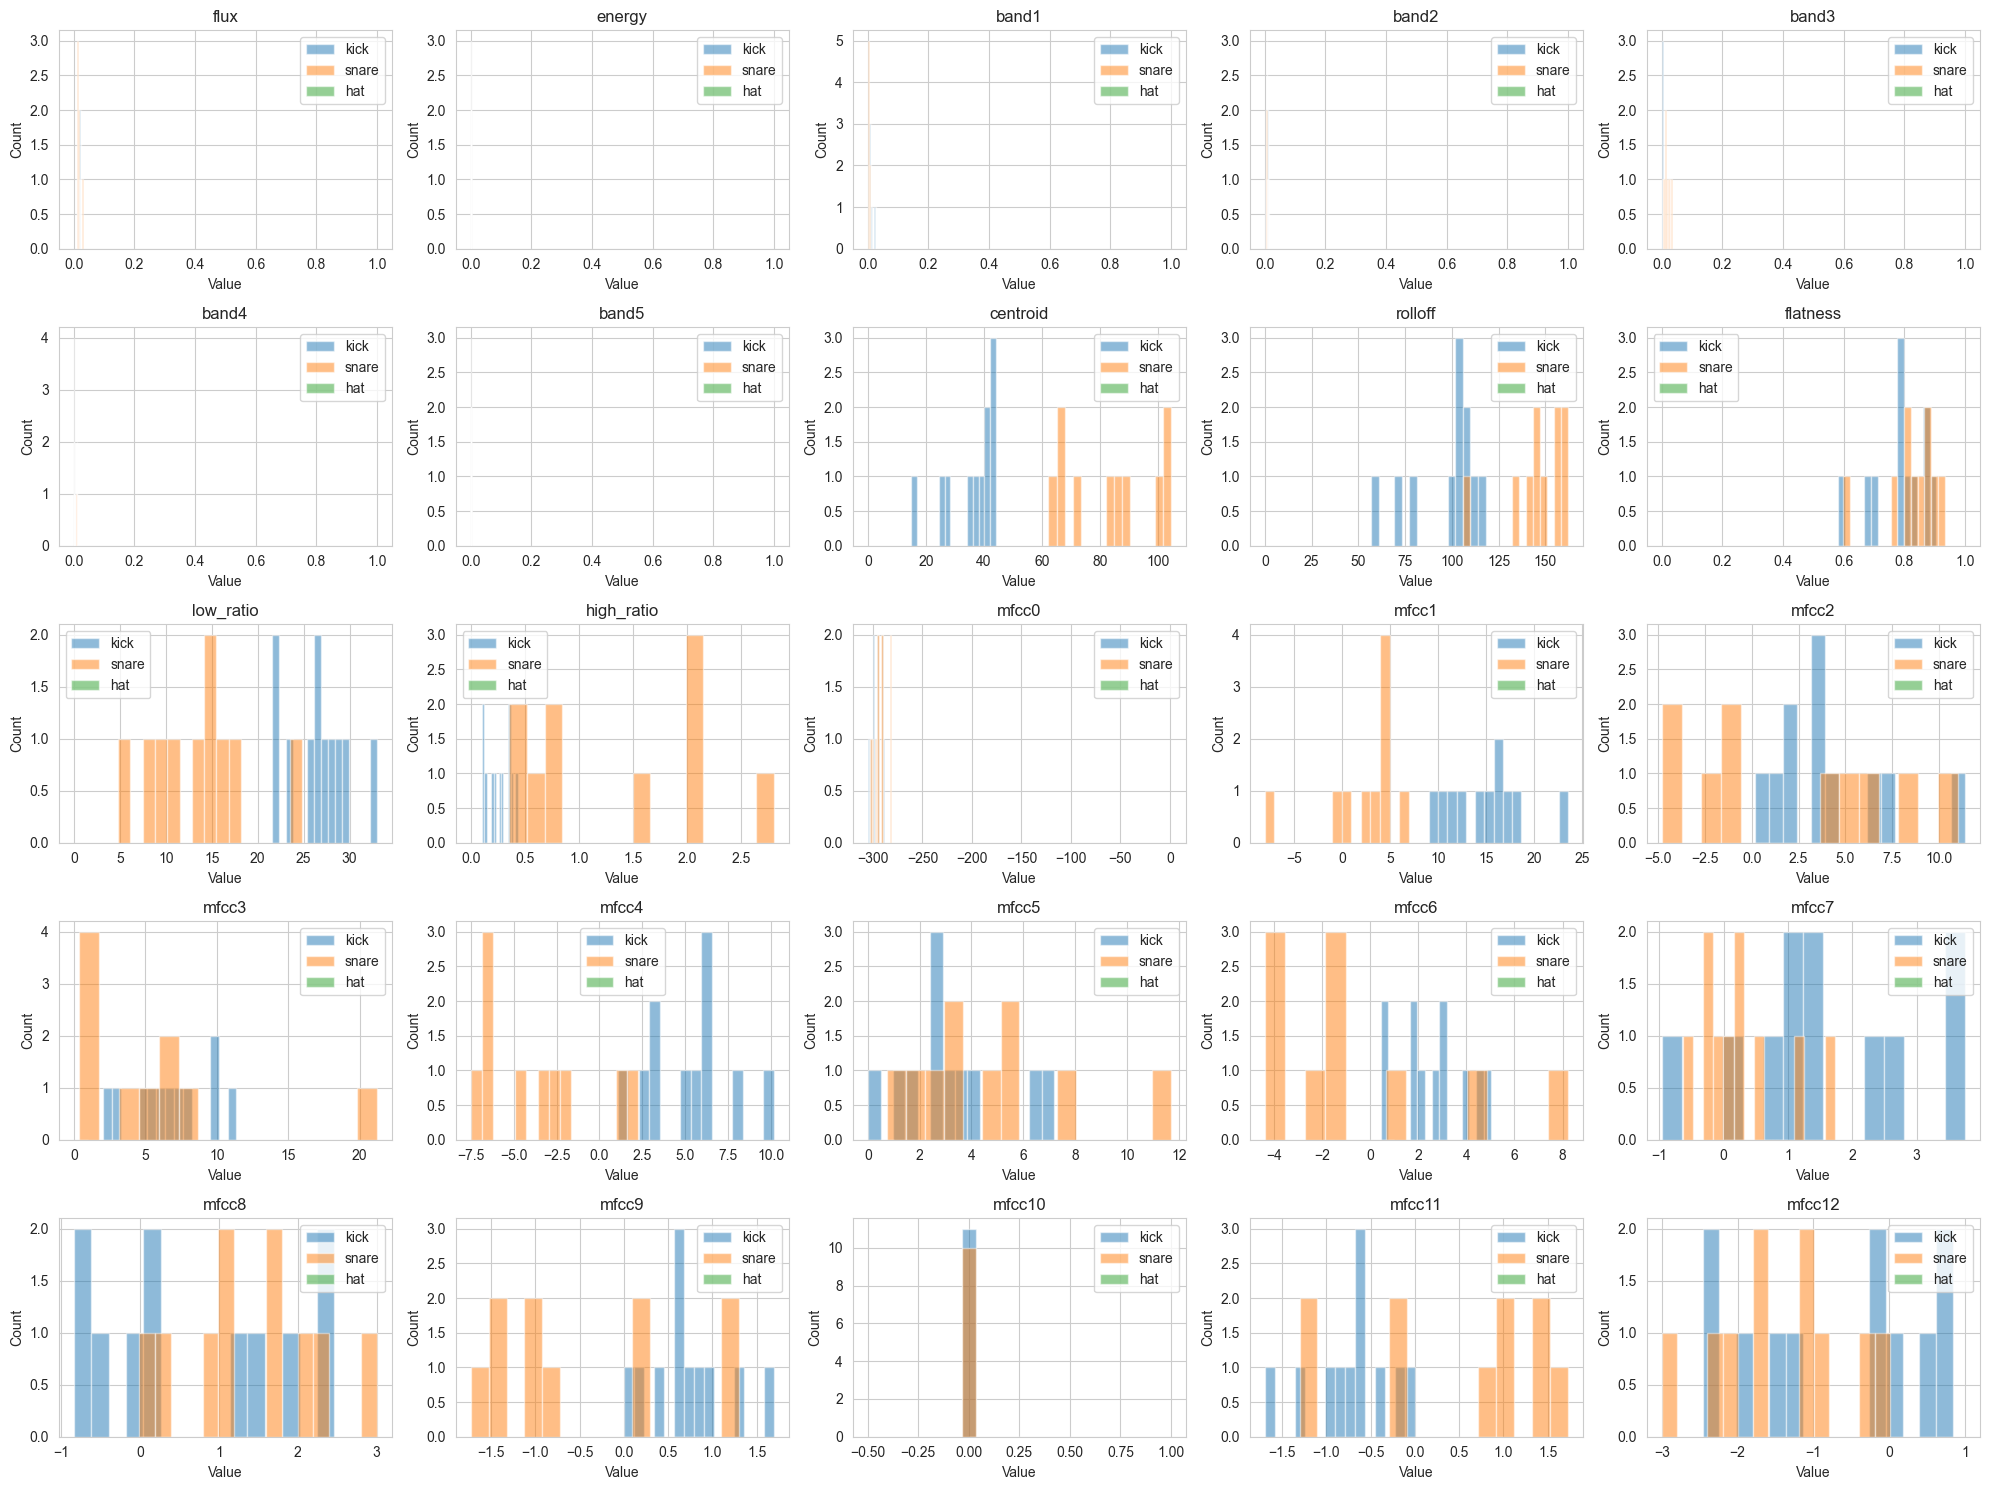

✓ Feature distributions plotted


In [5]:
# Plot distributions for all features
n_features = len(feature_cols)
n_cols = 5
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3))
axes = axes.flatten()

for idx, feature in enumerate(feature_cols):
    ax = axes[idx]
    
    for label in ['kick', 'snare', 'hat']:
        data = df[df['label'] == label][feature]
        ax.hist(data, alpha=0.5, label=label, bins=15)
    
    ax.set_title(feature)
    ax.legend()
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')

# Hide extra subplots
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print('✓ Feature distributions plotted')

## 3. Statistical Feature Ranking (ANOVA F-statistic)

Use ANOVA to rank features by their ability to discriminate between classes


FEATURE RANKING (by ANOVA F-score)
   feature  f_score  p_value  rank
      flux      NaN      NaN     1
    energy      NaN      NaN     2
     band1      NaN      NaN     3
     band2      NaN      NaN     4
     band3      NaN      NaN     5
     band4      NaN      NaN     6
     band5      NaN      NaN     7
  centroid      NaN      NaN     8
   rolloff      NaN      NaN     9
  flatness      NaN      NaN    10
 low_ratio      NaN      NaN    11
high_ratio      NaN      NaN    12
     mfcc0      NaN      NaN    13
     mfcc1      NaN      NaN    14
     mfcc2      NaN      NaN    15
     mfcc3      NaN      NaN    16
     mfcc4      NaN      NaN    17
     mfcc5      NaN      NaN    18
     mfcc6      NaN      NaN    19
     mfcc7      NaN      NaN    20
     mfcc8      NaN      NaN    21
     mfcc9      NaN      NaN    22
    mfcc10      NaN      NaN    23
    mfcc11      NaN      NaN    24
    mfcc12      NaN      NaN    25


/var/folders/gl/b9c7n7yj4s51tbbkxy1fzx4c0000gn/T/ipykernel_56528/903942644.py:10: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f_stat, p_val = f_oneway(kick_vals, snare_vals, hat_vals)


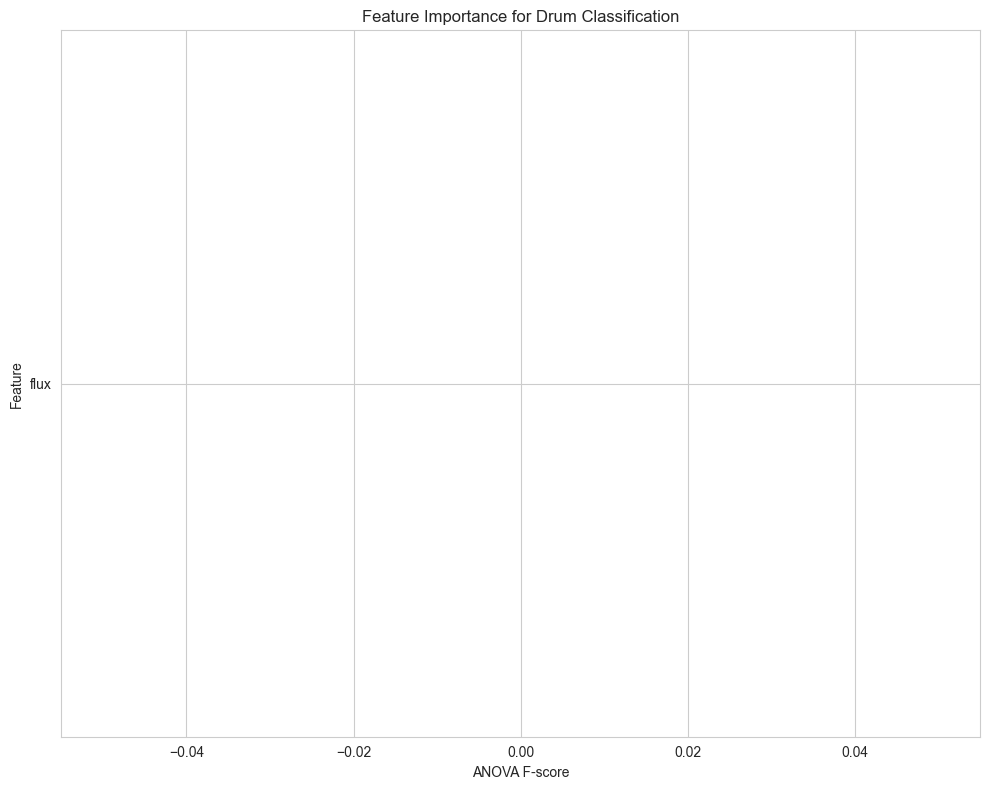

In [6]:
# Calculate ANOVA F-statistic for each feature
f_scores = []
p_values = []

for feature in feature_cols:
    kick_vals = df[df['label'] == 'kick'][feature]
    snare_vals = df[df['label'] == 'snare'][feature]
    hat_vals = df[df['label'] == 'hat'][feature]
    
    f_stat, p_val = f_oneway(kick_vals, snare_vals, hat_vals)
    f_scores.append(f_stat)
    p_values.append(p_val)

# Create ranking dataframe
feature_ranking = pd.DataFrame({
    'feature': feature_cols,
    'f_score': f_scores,
    'p_value': p_values
})

feature_ranking = feature_ranking.sort_values('f_score', ascending=False)
feature_ranking['rank'] = range(1, len(feature_ranking) + 1)

print('\n' + '='*60)
print('FEATURE RANKING (by ANOVA F-score)')
print('='*60)
print(feature_ranking.to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_ranking['feature'], feature_ranking['f_score'])
plt.xlabel('ANOVA F-score')
plt.ylabel('Feature')
plt.title('Feature Importance for Drum Classification')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Pairwise Feature Scatter Plots

Visualize the top discriminative features in 2D space


Top 6 discriminative features:
  1. low_ratio
  2. mfcc2
  3. mfcc1
  4. band1
  5. mfcc3
  6. centroid


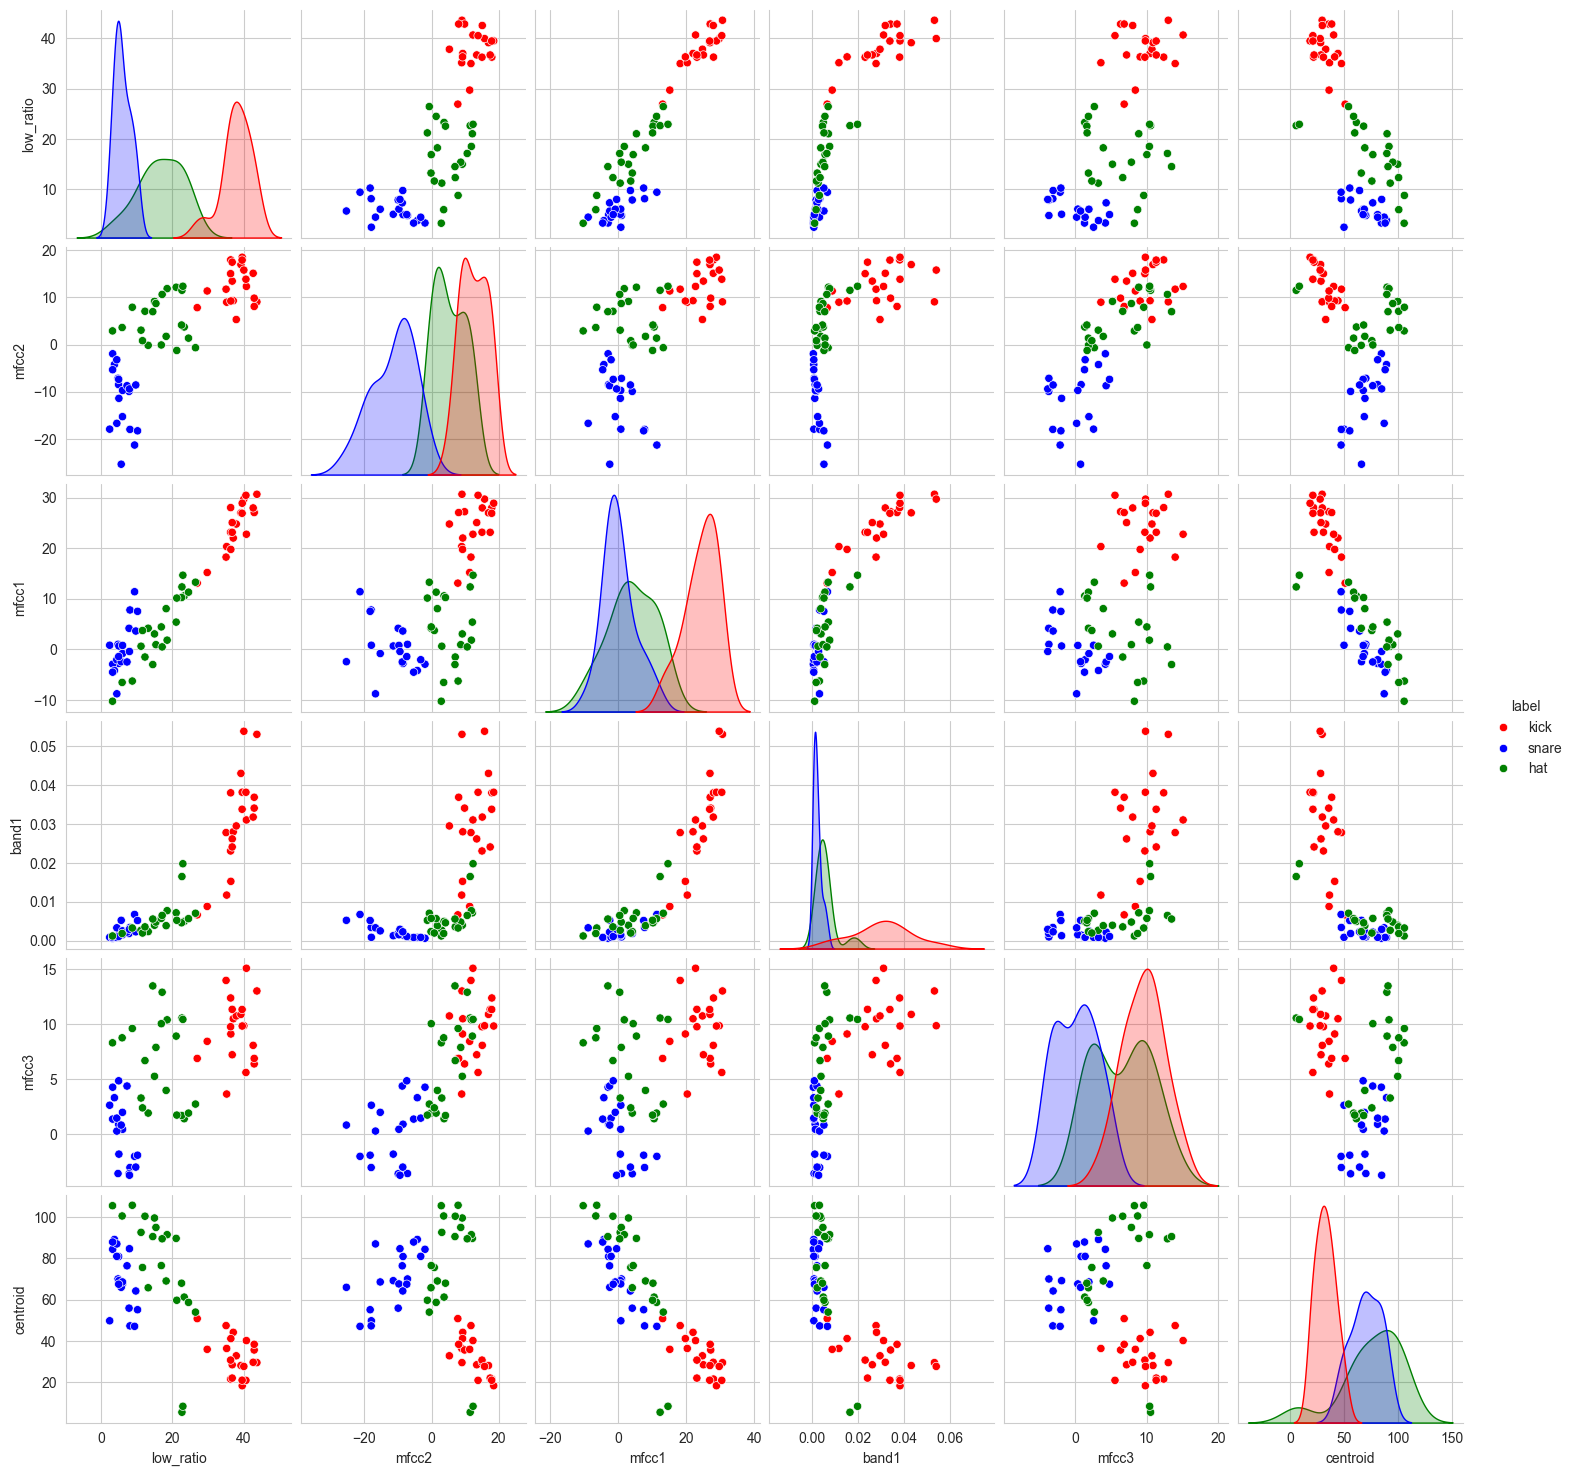

✓ Pairplot created


In [18]:
# Get top 6 features
top_features = feature_ranking.head(6)['feature'].values

print(f"\nTop 6 discriminative features:")
for i, feat in enumerate(top_features, 1):
    print(f"  {i}. {feat}")

# Create pairplot for top features
plot_df = df[['label'] + list(top_features)]
sns.pairplot(plot_df, hue='label', diag_kind='kde', palette={'kick': 'red', 'snare': 'blue', 'hat': 'green'})
plt.savefig('top_features_pairplot.png', dpi=150, bbox_inches='tight')
plt.show()

print('✓ Pairplot created')

## 5. Classification Performance vs. Number of Features

Test how accuracy changes as we add features (from most to least discriminative)

Top  1 features: CV accuracy = 0.936 (+/- 0.032)
Top  2 features: CV accuracy = 0.985 (+/- 0.031)
Top  3 features: CV accuracy = 0.985 (+/- 0.031)
Top  4 features: CV accuracy = 0.969 (+/- 0.038)
Top  5 features: CV accuracy = 0.968 (+/- 0.039)
Top  6 features: CV accuracy = 0.953 (+/- 0.039)
Top  7 features: CV accuracy = 0.953 (+/- 0.039)
Top  8 features: CV accuracy = 0.953 (+/- 0.039)
Top  9 features: CV accuracy = 0.953 (+/- 0.039)
Top 10 features: CV accuracy = 0.953 (+/- 0.039)


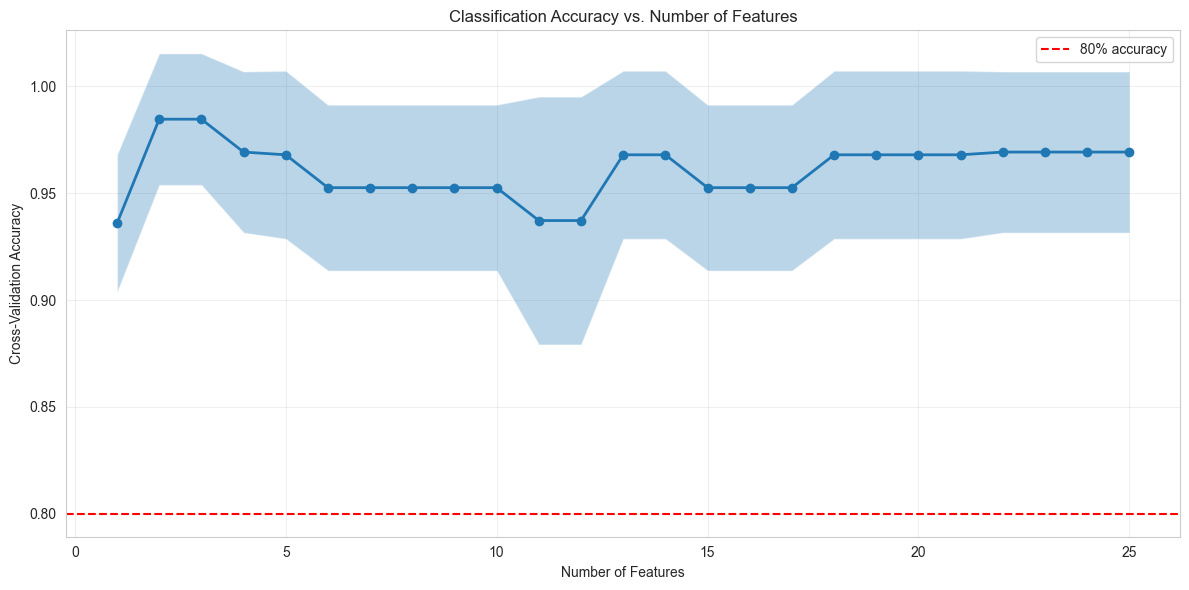


OPTIMAL FEATURE SET
Number of features: 2
CV accuracy: 0.985 (+/- 0.031)

Features: low_ratio, mfcc2


In [19]:
# Test classification with increasing number of features
results = []

for n_features in range(1, len(feature_cols) + 1):
    # Select top N features
    selected_features = feature_ranking.head(n_features)['feature'].values
    X_selected = df[selected_features].values
    
    # Normalize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_selected)
    
    # Train SVM with cross-validation
    clf = SVC(kernel='rbf', gamma='scale', C=1.0, random_state=42)
    cv_scores = cross_val_score(clf, X_scaled, y, cv=5)
    
    results.append({
        'n_features': n_features,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'features': ', '.join(selected_features)
    })
    
    if n_features <= 10:
        print(f"Top {n_features:2d} features: CV accuracy = {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")

results_df = pd.DataFrame(results)

# Plot accuracy vs. number of features
plt.figure(figsize=(12, 6))
plt.plot(results_df['n_features'], results_df['cv_mean'], marker='o', linewidth=2)
plt.fill_between(results_df['n_features'], 
                 results_df['cv_mean'] - results_df['cv_std'],
                 results_df['cv_mean'] + results_df['cv_std'],
                 alpha=0.3)
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Classification Accuracy vs. Number of Features')
plt.grid(True, alpha=0.3)
plt.axhline(y=0.8, color='r', linestyle='--', label='80% accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('accuracy_vs_features.png', dpi=150, bbox_inches='tight')
plt.show()

# Find optimal number of features (highest accuracy)
best_idx = results_df['cv_mean'].idxmax()
best_result = results_df.loc[best_idx]

print('\n' + '='*60)
print('OPTIMAL FEATURE SET')
print('='*60)
print(f"Number of features: {best_result['n_features']}")
print(f"CV accuracy: {best_result['cv_mean']:.3f} (+/- {best_result['cv_std']:.3f})")
print(f"\nFeatures: {best_result['features']}")

## 6. Confusion Matrix for Optimal Feature Set


CLASSIFICATION REPORT (Test Set)
              precision    recall  f1-score   support

         hat       1.00      1.00      1.00         5
        kick       1.00      1.00      1.00         4
       snare       1.00      1.00      1.00         4

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13



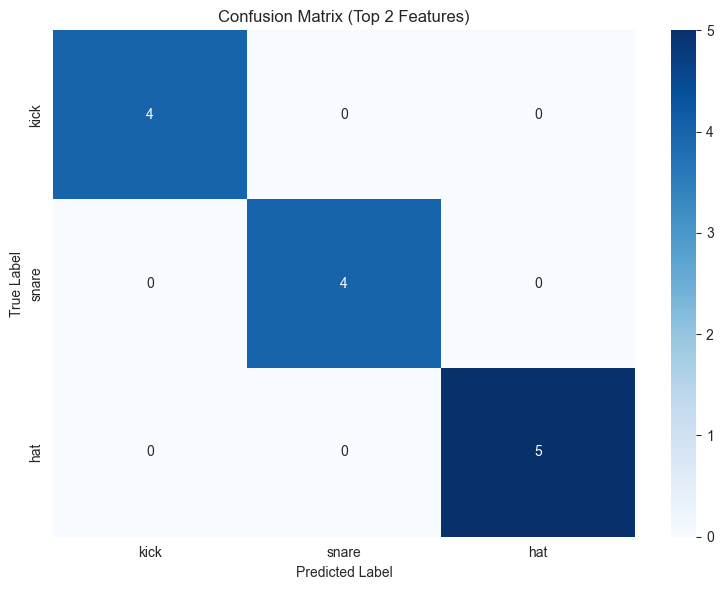

In [20]:
# Train final model with optimal features
optimal_n = int(best_result['n_features'])
optimal_features = feature_ranking.head(optimal_n)['feature'].values

X_optimal = df[optimal_features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_optimal)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Train final model
clf = SVC(kernel='rbf', gamma='scale', C=1.0, random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Classification report
print('\n' + '='*60)
print('CLASSIFICATION REPORT (Test Set)')
print('='*60)
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['kick', 'snare', 'hat'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['kick', 'snare', 'hat'],
            yticklabels=['kick', 'snare', 'hat'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title(f'Confusion Matrix (Top {optimal_n} Features)')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Feature Correlations

Check if any features are highly correlated (redundant)

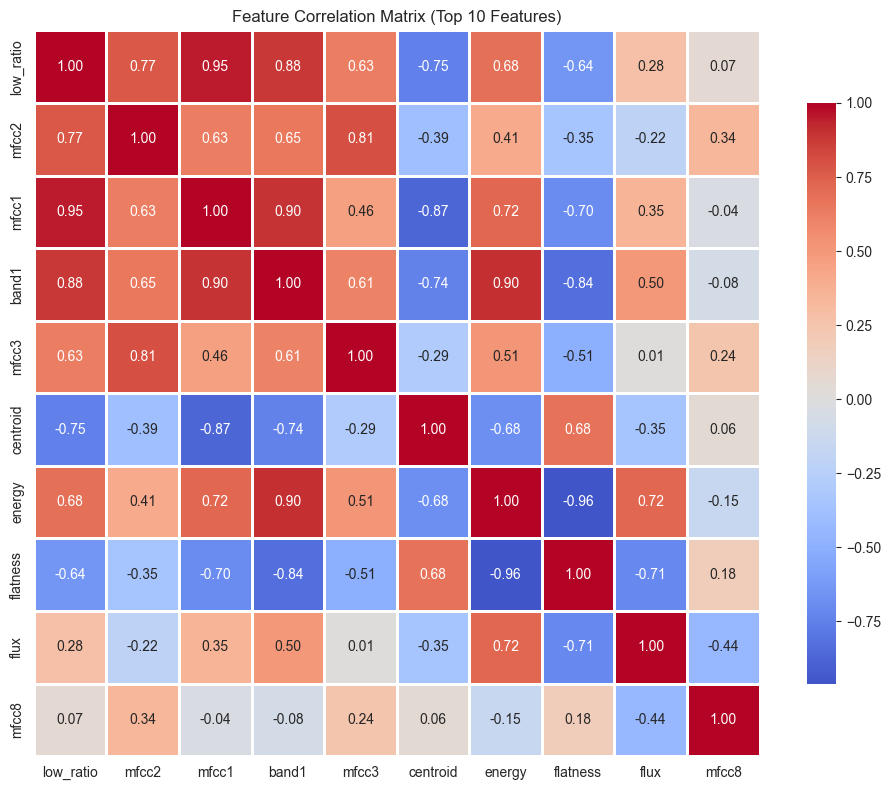


Highly correlated feature pairs (|r| > 0.7):
  low_ratio <-> mfcc2: 0.772
  low_ratio <-> mfcc1: 0.952
  low_ratio <-> band1: 0.881
  low_ratio <-> centroid: -0.748
  mfcc2 <-> mfcc3: 0.806
  mfcc1 <-> band1: 0.898
  mfcc1 <-> centroid: -0.872
  mfcc1 <-> energy: 0.724
  band1 <-> centroid: -0.741
  band1 <-> energy: 0.902
  band1 <-> flatness: -0.835
  energy <-> flatness: -0.960
  energy <-> flux: 0.724
  flatness <-> flux: -0.712


In [21]:
# Compute correlation matrix for top features
top_10_features = feature_ranking.head(10)['feature'].values
corr_matrix = df[top_10_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix (Top 10 Features)')
plt.tight_layout()
plt.savefig('feature_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

# Find highly correlated pairs
print('\nHighly correlated feature pairs (|r| > 0.7):')
high_corr_pairs = []
for i in range(len(corr_matrix)):
    for j in range(i+1, len(corr_matrix)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append((corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

if high_corr_pairs:
    for feat1, feat2, corr in high_corr_pairs:
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")
else:
    print('  None found (good - features are independent!)')

## 8. Recommended Feature Set for User Training

Based on the analysis above, recommend a minimal feature set that:
1. Achieves high accuracy (>80%)
2. Uses fewest features (for faster extraction)
3. Has low inter-feature correlation (independent information)

In [22]:
# Find minimal feature set that achieves >80% accuracy
threshold = 0.80
minimal_features = None

for idx, row in results_df.iterrows():
    if row['cv_mean'] >= threshold:
        minimal_features = row
        break

print('\n' + '='*70)
print('RECOMMENDED FEATURE SET FOR USER TRAINING')
print('='*70)

if minimal_features is not None:
    rec_n = int(minimal_features['n_features'])
    rec_features = feature_ranking.head(rec_n)['feature'].values
    
    print(f"\nMinimal features for >{threshold*100:.0f}% accuracy: {rec_n} features")
    print(f"Expected accuracy: {minimal_features['cv_mean']:.1%} (+/- {minimal_features['cv_std']:.1%})")
    print(f"\nRecommended features:")
    for i, feat in enumerate(rec_features, 1):
        f_score = feature_ranking[feature_ranking['feature'] == feat]['f_score'].values[0]
        print(f"  {i}. {feat:12s} (F-score: {f_score:.2f})")
    
    print(f"\n{'='*70}")
    print('IMPLEMENTATION NOTES:')
    print('='*70)
    print(f"- These {rec_n} features balance accuracy and computational efficiency")
    print(f"- Users only need 10 samples per class (30 total) for training")
    print(f"- Real-time extraction should be <10ms with these features")
    print(f"- Consider removing MFCC if computation is still too slow")
    
    # Test without MFCCs
    non_mfcc_features = [f for f in rec_features if not f.startswith('mfcc')]
    if len(non_mfcc_features) < rec_n:
        X_no_mfcc = df[non_mfcc_features].values
        scaler_no_mfcc = StandardScaler()
        X_scaled_no_mfcc = scaler_no_mfcc.fit_transform(X_no_mfcc)
        
        clf_no_mfcc = SVC(kernel='rbf', gamma='scale', C=1.0, random_state=42)
        cv_scores_no_mfcc = cross_val_score(clf_no_mfcc, X_scaled_no_mfcc, y, cv=5)
        
        print(f"\nAlternative (no MFCC): {len(non_mfcc_features)} features")
        print(f"  Features: {', '.join(non_mfcc_features)}")
        print(f"  Accuracy: {cv_scores_no_mfcc.mean():.1%} (+/- {cv_scores_no_mfcc.std():.1%})")
        
else:
    print(f"\nWarning: Current data cannot achieve {threshold*100:.0f}% accuracy!")
    print(f"Best achieved: {results_df['cv_mean'].max():.1%}")
    print(f"\nRecommendations:")
    print(f"  1. Collect more training samples (aim for 30+ per class)")
    print(f"  2. Ensure consistent beatbox technique")
    print(f"  3. Check microphone quality and gain settings")


RECOMMENDED FEATURE SET FOR USER TRAINING

Minimal features for >80% accuracy: 1 features
Expected accuracy: 93.6% (+/- 3.2%)

Recommended features:
  1. low_ratio    (F-score: 260.40)

IMPLEMENTATION NOTES:
- These 1 features balance accuracy and computational efficiency
- Users only need 10 samples per class (30 total) for training
- Real-time extraction should be <10ms with these features
- Consider removing MFCC if computation is still too slow


## 9. Summary and Next Steps

In [23]:
print('\n' + '='*70)
print('ANALYSIS SUMMARY')
print('='*70)

print(f"\n📊 Dataset:")
print(f"   Total samples: {len(df)}")
print(f"   - Kicks: {len(df[df['label']=='kick'])}")
print(f"   - Snares: {len(df[df['label']=='snare'])}")
print(f"   - Hats: {len(df[df['label']=='hat'])}")

print(f"\n🎯 Best Performance:")
print(f"   {best_result['n_features']} features")
print(f"   {best_result['cv_mean']:.1%} accuracy (+/- {best_result['cv_std']:.1%})")

print(f"\n⚡ Recommended for Production:")
if minimal_features is not None:
    print(f"   {rec_n} features")
    print(f"   {minimal_features['cv_mean']:.1%} accuracy")
    print(f"   Features: {', '.join(rec_features[:5])}...")

print(f"\n📈 Top 3 Most Discriminative Features:")
for i in range(min(3, len(feature_ranking))):
    feat = feature_ranking.iloc[i]
    print(f"   {i+1}. {feat['feature']:12s} (F-score: {feat['f_score']:.2f})")

print(f"\n✅ Next Steps:")
print(f"   1. Update feature_extraction.ck to use recommended features")
print(f"   2. Update train_classifier.py to use optimal feature subset")
print(f"   3. Test real-time classification latency")
print(f"   4. Collect more samples if accuracy < 80%")
print(f"\n" + '='*70)


ANALYSIS SUMMARY

📊 Dataset:
   Total samples: 63
   - Kicks: 21
   - Snares: 20
   - Hats: 22

🎯 Best Performance:
   2 features
   98.5% accuracy (+/- 3.1%)

⚡ Recommended for Production:
   1 features
   93.6% accuracy
   Features: low_ratio...

📈 Top 3 Most Discriminative Features:
   1. low_ratio    (F-score: 260.40)
   2. mfcc2        (F-score: 120.64)
   3. mfcc1        (F-score: 110.33)

✅ Next Steps:
   1. Update feature_extraction.ck to use recommended features
   2. Update train_classifier.py to use optimal feature subset
   3. Test real-time classification latency
   4. Collect more samples if accuracy < 80%

